In [48]:
import skimage
import keras
import numpy as np
from keras import backend as K
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from keras import Model
from keras.layers import concatenate
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt

In [49]:
num_classes = 10
# input image dimensions
img_rows, img_cols = 28, 28
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [50]:
x_train = np.array([skimage.transform.resize(image, (32, 32)) for image in np.expand_dims(x_train, -1)])[:10000]
x_test = np.array([skimage.transform.resize(image, (32, 32)) for image in np.expand_dims(x_test, -1)])
# x_train = x_train.reshape(-1,28,28,1)[:10000]
# x_test = x_test.reshape(-1,28,28,1)
y_train = y_train.astype('int')[:10000]
y_test = y_test.astype('int')

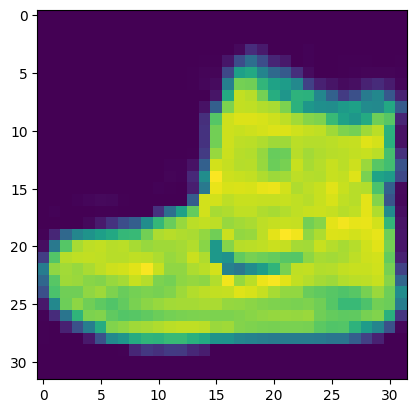

In [52]:
x_train.shape

plt.imshow(x_train[0])

In [53]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]

print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [942, 1027, 1016, 1019, 974, 989, 1021, 1022, 990, 1000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [54]:
class ResidualBlock(Model):
    def __init__(self, channel_in = 64, channel_out = 256):
        super().__init__()

        channel = channel_out // 4

        self.conv1 = Conv2D(channel, kernel_size = (1, 1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)
        self.conv2 = Conv2D(channel, kernel_size = (3, 3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)
        self.conv3 = Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
        self.bn3 = BatchNormalization()
        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)

    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.av2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av3(h)
        return y

    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)

    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size = (1, 1), padding = "same")

In [55]:
class DenceNet(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()

        self._layers = [
            # conv1
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu),
            # conv2_x
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"),
            ResidualBlock(64, 256),
            [
                ResidualBlock(256, 256) for _ in range(2)
            ],
            # conv3_x
            Conv2D(512, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(512, 512) for _ in range(4)
            ],
            # conv4_x
            Conv2D(1024, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(1024, 1024) for _ in range(6)
            ],
            # conv5_x
            Conv2D(2048, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(2048, 2048) for _ in range(3)
            ],
            # last part
            GlobalAveragePooling2D(),
            Dense(1000, activation = tf.nn.relu),
            Dense(output_dim, activation = tf.nn.softmax)
        ]

    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)
            else:
                x = layer(x)
        return x

In [56]:
model = DenceNet((28, 28, 1), 10)
model.build(input_shape = (None, 28, 28, 1))
model.summary()

Model: "dence_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         multiple                  3200      
                                                                 
 batch_normalization_98 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 activation_98 (Activation)  multiple                  0         
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 residual_block_32 (Residual  multiple                 75904     
 Block)                                                          
                                                       

In [57]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
        
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

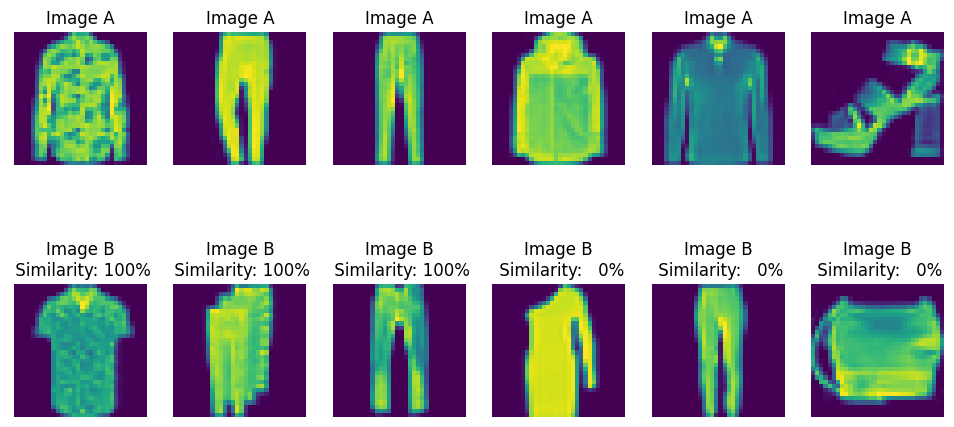

In [58]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
  ax1.imshow(c_a[:,:,0])
  ax1.set_title('Image A')
  ax1.axis('off')
  ax2.imshow(c_b[:,:,0])
  ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
  ax2.axis('off')

In [59]:
%%time
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs = 4, batch_size = 16, validation_split = 0.2, verbose = 1)

Epoch 1/4
500/500 [==============================] - 656s 1s/step - loss: 1.3403 - accuracy: 0.6199 - val_loss: 0.9987 - val_accuracy: 0.6160
Epoch 2/4
500/500 [==============================] - 635s 1s/step - loss: 0.6505 - accuracy: 0.7615 - val_loss: 0.6915 - val_accuracy: 0.7520
Epoch 3/4
500/500 [==============================] - 632s 1s/step - loss: 0.5691 - accuracy: 0.7984 - val_loss: 0.5872 - val_accuracy: 0.7820
Epoch 4/4
500/500 [==============================] - 630s 1s/step - loss: 0.5530 - accuracy: 0.8055 - val_loss: 0.6225 - val_accuracy: 0.7800
CPU times: user 54min 52s, sys: 55.6 s, total: 55min 47s
Wall time: 42min 34s


In [77]:
img_a_in = tf.keras.layers.Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = tf.keras.layers.Input(shape=x_train.shape[1:], name='ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name='features')
features = tf.keras.layers.Dense(16, activation='relu')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='relu')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs=[img_a_feat, img_b_feat], outputs=[features], name='Siamese_model')
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 features (Concatenate)         (None, 20)           0           ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 dense_15 (Dense)               (None, 16)           336         ['features[1][0]']   

In [78]:
def show_model_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title(f'Image A\n Actual: {100 * c_d}')
        ax1.axis('off')
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title(f'Image B\n Predicted: {int(100 * p_d[0])}')
        ax2.axis('off')
        
    return fig

1/1 [==============================] - 0s 69ms/step


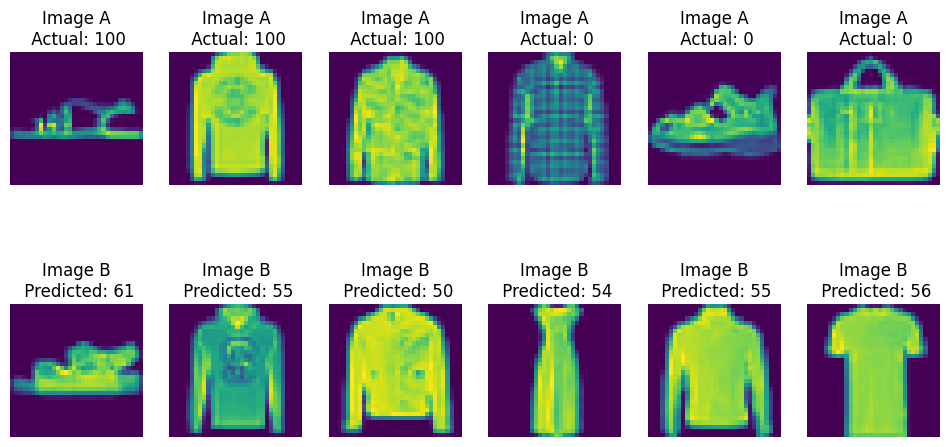

In [79]:
_ = show_model_output()

In [80]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size // 2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

In [81]:
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(
                                siam_gen(train_groups),
                                steps_per_epoch=500,
                                validation_data=([model.predict(valid_a), model.predict(valid_b)], valid_sim),
                                epochs=2,
                                verbose=True)

1/1 [==============================] - 0s 102ms/step
Epoch 1/2
500/500 [==============================] - 219s 317ms/step - loss: 0.5926 - mae: 0.4156 - val_loss: 0.5244 - val_mae: 0.3950
Epoch 2/2
1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 19ms/step


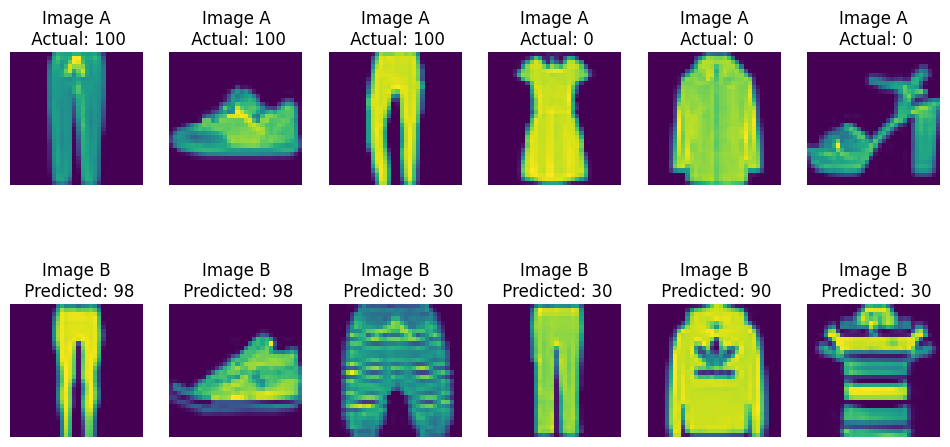

In [82]:
_ = show_model_output()

In [83]:
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

79/79 [==============================] - 25s 317ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 0.329s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000061
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.475281
[t-SNE] KL divergence a

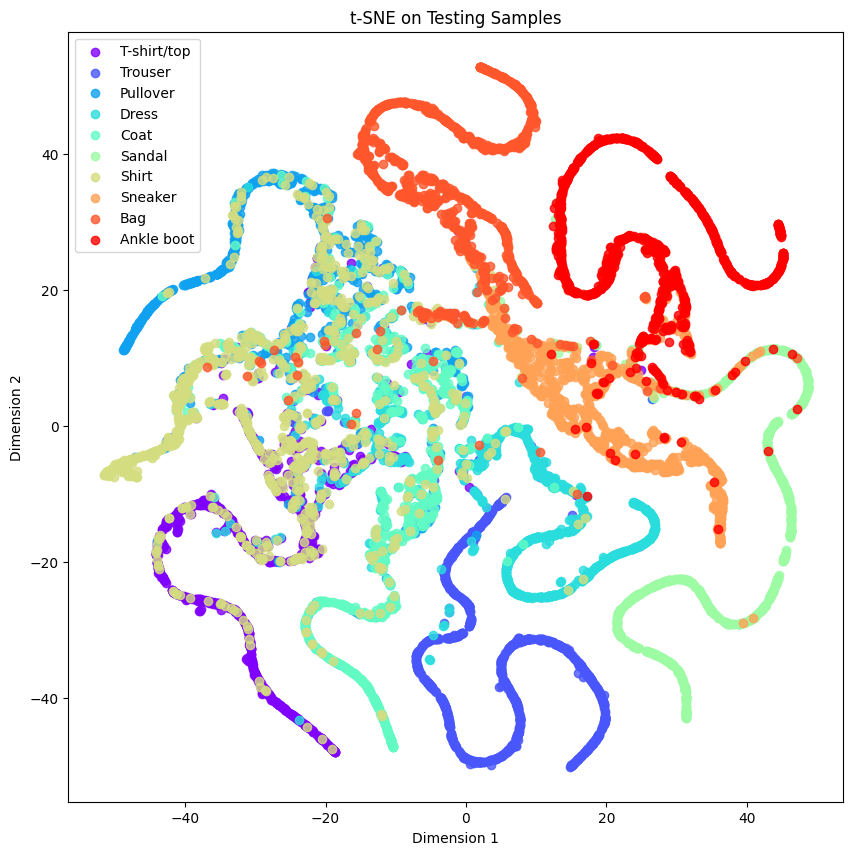

In [84]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(tsne_features[np.where(y_test == c_group), 0],
              tsne_features[np.where(y_test == c_group), 1],
              marker='o',
              color=c_color,
              linewidth=1,
              alpha=0.8,
              label=c_label)
    
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show(block=False)